In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlscorecheck.auc import integrate_roc_curve, auc_min, auc_max, roc_min, roc_max, auc_rmin, auc_maxa, roc_maxa, roc_rmin, auc_estimator, p_norm_fit, p_norm_fit_best

from sklearn.metrics import r2_score as r2_score_orig
from sklearn.metrics import mean_absolute_percentage_error as mean_absolute_percentage_error_orig

from scipy.stats import beta, binom

from scipy.stats import skew, skewtest

In [2]:
p_norm_fit(np.array([0.0, 0.024, 1.0]), np.array([0.0, 0.776, 1.0]))

np.float64(0.5474811673454448)

In [ ]:
def p_norm_fit_best(x, y, bracket=(-5, 3), mode='implicit', p=None, n=None, max_acc=None):
    exp = np.logspace(bracket[0], bracket[1], 2000)
    err = np.mean(np.abs(1 - x**exp[:, None] - y**exp[:, None])**1, axis=1)
    if max_acc is not None:
        z = np.linspace(0, 1, 100)
        fprs = (z)[:, None]
        tprs = ((1 - z[:, None]**exp)**(1/exp))
        tmp = (fprs * n + tprs * p) / (p + n)
        max_accs = np.max(tmp, axis=0)
        mask = max_accs > max_acc
        err[mask] = np.inf
    
    return exp[np.argmin(err)]

In [30]:
p_norm_fit_best(1.0 - np.array([0.0, 0.024, 1.0]), np.array([0.0, 0.776, 1.0]), p=30_000, n=300_000, max_acc=0.98)

(100, 2000) (2000,)
[[0.09090909 0.09090909 0.09090909 ... 0.09090909 0.09090909 0.09090909]
 [0.00918274 0.00918274 0.00918274 ... 0.10009183 0.10009183 0.10009183]
 [0.01836547 0.01836547 0.01836547 ... 0.10927456 0.10927456 0.10927456]
 ...
 [0.89072544 0.89072544 0.89072544 ... 0.98163453 0.98163453 0.98163453]
 [0.89990817 0.89990817 0.89990817 ... 0.99081726 0.99081726 0.99081726]
 [0.90909091 0.90909091 0.90909091 ... 0.90909091 0.90909091 0.90909091]]
[0.90909091 0.90909091 0.90909091 ... 0.99081726 0.99081726 0.99081726]


np.float64(7.226524255927731)

In [11]:
def r2_score(y_true, y_pred):
    data = np.vstack([y_true, y_pred]).T
    data = data[~np.any(np.isnan(data), axis=1)]
    return r2_score_orig(data[:, 0], data[:, 1])

def mean_absolute_percentage_error(y_true, y_pred):
    data = np.vstack([y_true, y_pred]).T
    data = data[~np.any(np.isnan(data), axis=1)]
    return mean_absolute_percentage_error_orig(data[:, 0], data[:, 1])

In [12]:
input_label = 'single'

#input_file = f'processed-{input_label}-50k-rs6-clipped.csv'
input_file = f'processed-{input_label}-100k.csv'

#equalize = 'n_nodes_bins'
equalize = 'auc'
noedge = False

In [13]:
def extract_n_neighbors(params):
    params = eval(params)
    if 'n_neighbors' in params:
        return params['n_neighbors']
    return 1

In [14]:
data = pd.read_csv(input_file)
#data = pd.concat([data, pd.read_csv('processed-single-50k-rs6-clipped.csv')])

FileNotFoundError: [Errno 2] No such file or directory: 'processed-single-100k.csv'

In [ ]:
data = data[data['sens'] > 1 - data['spec']]

In [ ]:
data = data[~data['dataset'].isin(['KC1'])]
data['n_neighbors'] = data['classifier_params'].apply(extract_n_neighbors)
#data['n_nodes_per_size'] = data['n_nodes']/(data['p'] + data['n'])
data['n_nodes_per_size'] = data['n_nodes']/(data.apply(lambda row: 2*min(row['p'], row['n']) + 2, axis=1))

(array([37682.,  5835.,  2188.,  1213.,   649.,   301.,   144.,   107.,
          123.,    90.]),
 array([  3. ,  55.5, 108. , 160.5, 213. , 265.5, 318. , 370.5, 423. ,
        475.5, 528. ]),
 <BarContainer object of 10 artists>)

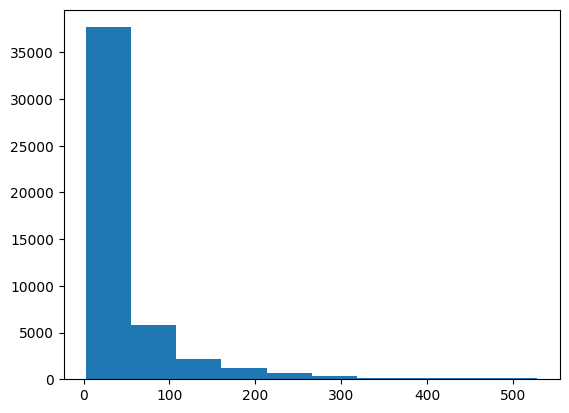

In [ ]:
plt.hist(data['n_nodes'])

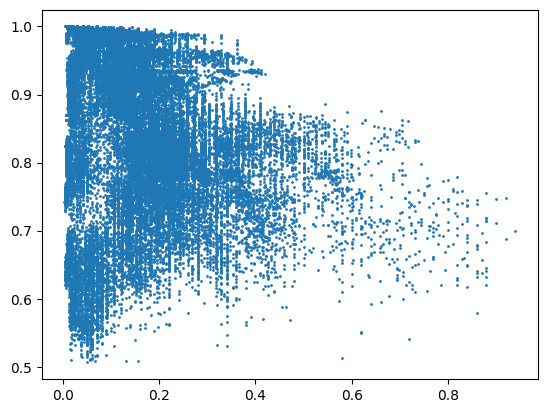

In [ ]:
#plt.scatter(data['n_nodes']/(data['p'] + data['n']), data['auc'], s=1)
plt.scatter(data['n_nodes']/data.apply(lambda row: 2*min(row['p'], row['n']) + 2, axis=1), data['auc'], s=1)

In [ ]:
bins = np.percentile(data['n_nodes'], np.linspace(20, 100, 8))
bins = (bins[:-1] + bins[1:])/2
while bins[0] == bins[1]:
    bins = bins[1:]
#bins = np.hstack([bins, [np.percentile(data['n_nodes'], 95)]])
#bins = np.array([6, 15, 25, 45, 90, 135])

In [ ]:
data.columns

Index(['p', 'n', 'k', 'dataset', 'classifier', 'classifier_params', 'best_acc',
       'best_sens', 'best_spec', 'best_acc_train', 'best_sens_train',
       'best_spec_train', 'acc', 'sens', 'spec', 'auc', 'acc_train',
       'sens_train', 'spec_train', 'auc_train', 'n_nodes', 'n_nodes_train',
       'avg_n_nodes', 'avg_n_nodes_train', 'fprs', 'tprs', 'fprs_train',
       'tprs_train', 'fracs', 'exp_fpr', 'exp_tpr', 'r2_fpr', 'r2_tpr',
       'r2_roc', 'auc_min', 'auc_min_best', 'auc_max', 'auc_max_best',
       'auc_maxa_best', 'auc_rmin', 'auc_rmin_best', 'auc_min_max_normal_nw',
       'auc_min_max_best_nw', 'auc_rmin_max_normal_nw', 'auc_rmin_max_best_nw',
       'auc_min_maxa_best_nw', 'auc_rmin_maxa_best_nw',
       'auc_integral_joint_best', 'aijb_p_fpr', 'aijb_p_tpr',
       'auc_integral_roc', 'air_p_fpr', 'air_p_tpr', 'auc_integral_roc_best',
       'airb_p_fpr', 'airb_p_tpr', 'max_acc_integral', 'max_acc_min',
       'max_acc_max', 'n_neighbors', 'n_nodes_per_size'],
      d

In [ ]:
fprs, tprs, air_p_fpr, air_p_tpr, spec, sens = data.iloc[0][['fprs', 'tprs', 'air_p_fpr', 'air_p_tpr', 'spec', 'sens']]

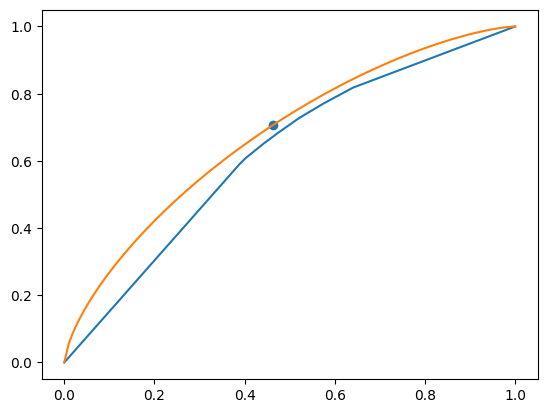

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(np.array(eval(fprs)), np.array(eval(tprs)))
plt.plot(x, (1 - (1 - x)**air_p_fpr)**(1/air_p_fpr))
plt.scatter([1 - spec], [sens])

In [ ]:
def downsample_roc_0(fpr0, tpr0, p, n_nodes, n_samples):
    fprs = np.zeros((n_samples, n_nodes + 3), dtype=float)
    tprs = np.zeros((n_samples, n_nodes + 3), dtype=float)

    fprs[:, 1] = fpr0
    fprs[:, 2] = 1.0
    tprs[:, 1] = tpr0
    tprs[:, 2] = 1.0

    random_samples = np.random.random_sample((n_samples, n_nodes))
    fprs[:, 3:] = random_samples
    tprs[:, 3:] = (1 - (1 - random_samples)**p)**(1/p)

    sorting = np.argsort(fprs)
    fprs = fprs[np.arange(fprs.shape[0])[:, None], sorting]
    tprs = tprs[np.arange(fprs.shape[0])[:, None], sorting]

    return fprs, tprs

In [ ]:
fprs, tprs = downsample_roc_0(0.024, 0.776, 3, 4, 10)

NameError: name 'np' is not defined

In [ ]:
for idx in range(len(fprs)):
    plt.plot(fprs[idx], tprs[idx])

In [ ]:
def downsample_roc_1(fpr0, tpr0, p, n_nodes):
    fprs = np.linspace(0, 1, 100)
    tprs = (1 - (1 - x)**p)**(1/p)



In [407]:
data['n_nodes_bin'] = data.apply(lambda row: bins[np.argmin(np.abs(bins - row['n_nodes']))], axis=1)

In [408]:
data['auc_final'] = (data['auc_min_max_normal_nw'] + data['auc_integral_roc'])/2
data['auc_final_best'] = (data['auc_min_max_best_nw'] + data['auc_integral_joint_best'])/2

data['max_acc_min_max'] = (data['max_acc_min'] + data['max_acc_max'])/2

data['max_acc_final'] = (data['max_acc_integral'] + data['max_acc_min_max'])/2

In [409]:
print(equalize)

auc


In [410]:
if equalize == 'auc':
    n_samples = 1000

    tmp = []
    lower_bounds = np.linspace(0.5, 1.0, 11)
    for lower, upper in zip(lower_bounds[:-1], lower_bounds[1:]):
        if upper == 1.0:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] <= upper)]
        else:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] < upper)]
        if len(tmp2) == 0:
            continue
        if len(tmp2) > n_samples:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=False))
        else:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=True))
    data_eq = pd.concat(tmp)
else:
    data_eq = data

if equalize == 'n_nodes_bins':
    n_samples = 1000

    tmp = []
    bins = data['n_nodes_bin'].drop_duplicates().values
    for bin in bins:
        tmp2 = data[data['n_nodes_bin'] == bin]
        if len(tmp2) > n_samples:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=False))
        else:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=True))
    data_eq = pd.concat(tmp)
else:
    data_eq = data



if noedge:
    data_eq = data_eq[(~data_eq['best_sens'].isin([0])) & (~data_eq['best_spec'].isin([0]))]
    data_eq = data_eq[(~data_eq['sens'].isin([0])) & (~data_eq['spec'].isin([0]))]

    data = data[(~data['best_sens'].isin([0])) & (~data['best_spec'].isin([0]))]
    data = data[(~data['sens'].isin([0])) & (~data['spec'].isin([0]))]

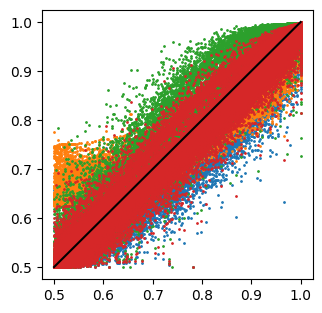

In [440]:
plt.figure(figsize=(3.5, 3.5))
plt.plot([0.5, 1.0], [0.5, 1.0], color='black')
plt.scatter(data_eq['auc'], data_eq['auc_min_max_normal_nw'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_rmin_max_normal_nw'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_integral_roc'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_final'], s=1)

In [412]:
skew(data_eq['auc'] - data_eq['auc_final'])

np.float64(0.01993053069422745)

In [413]:
skewtest(data_eq['auc'] - data_eq['auc_final'])

SkewtestResult(statistic=np.float64(1.7911877436895294), pvalue=np.float64(0.07326317234103441))

In [414]:
(r2_score(data_eq['auc'], data_eq['auc_min_max_normal_nw']),
r2_score(data_eq['auc'], data_eq['auc_rmin_max_normal_nw']),
r2_score(data_eq['auc'], data_eq['auc_integral_roc']),
r2_score(data_eq['auc'], data_eq['auc_final']))

(0.9189290692080273,
 0.8598527080892462,
 0.9427438828518209,
 0.9656562587236314)

In [415]:
def calculate_r2(pdf, target):
    """if np.std(pdf[target]) < 1e-6:
        return None
    else:"""
    #r2 = r2_score(pdf['auc'], pdf[target])
    r2 = mean_absolute_percentage_error(pdf['auc'], pdf[target])
    if r2 < 0:
        return 0.0
    else:
        return r2

In [416]:
tmp = data_eq.groupby(['n_nodes_bin', 'classifier']).apply(lambda pdf: 
        pd.Series({'r2_min_max': calculate_r2(pdf, 'auc_min_max_normal_nw'),
                   'r2_rmin_max': calculate_r2(pdf, 'auc_rmin_max_normal_nw'),
                   'r2_integral': calculate_r2(pdf, 'auc_integral_roc'),
                   'r2_final': calculate_r2(pdf, 'auc_final')})).reset_index(drop=False)

/tmp/ipykernel_1181145/251532501.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data_eq.groupby(['n_nodes_bin', 'classifier']).apply(lambda pdf:


In [417]:
tmp

,n_nodes_bin,classifier,r2_min_max,r2_rmin_max,r2_integral,r2_final
0,5.0,DecisionTreeClassifier,0.002695,0.089291,0.076753,0.038332
1,5.0,KNeighborsClassifier,0.031263,0.050142,0.032373,0.021503
2,5.0,RandomForestClassifier,0.013051,0.012444,0.015447,0.011970
3,5.0,SVC,0.015363,0.015709,0.011175,0.012388
4,5.0,XGBClassifier,0.012524,0.011665,0.010402,0.010297
5,8.5,DecisionTreeClassifier,0.038488,0.090330,0.068438,0.038121
6,8.5,KNeighborsClassifier,0.052396,0.075121,0.030762,0.029069
7,8.5,RandomForestClassifier,0.036183,0.032246,0.022583,0.021374
8,8.5,SVC,0.029312,0.028648,0.023413,0.021046
9,8.5,XGBClassifier,0.034256,0.030411,0.023021,0.022569


In [418]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'black', 'yellow']

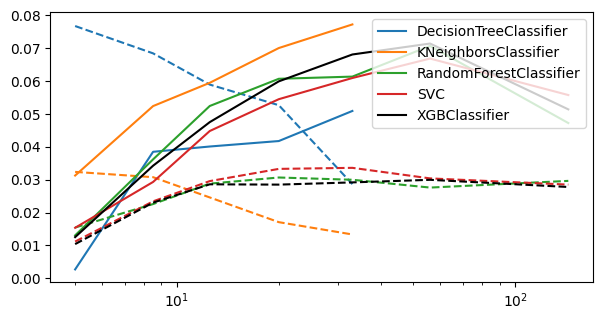

In [419]:
plt.figure(figsize=(7, 3.5))
for idx, classifier in enumerate(tmp['classifier'].drop_duplicates()):
    tmp2 = tmp[tmp['classifier'] == classifier]
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_min_max'], ls='solid', c=colors[idx], label=classifier)
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_integral'], ls='--', c=colors[idx])
    #plt.plot(tmp2['n_nodes_bin'], tmp2['r2_final'], ls=':', c=colors[idx])
plt.xscale('log')
plt.legend()

In [420]:
tmp = data.groupby('n_nodes_bin').apply(lambda pdf: 
        pd.Series({'r2_min_max': r2_score(pdf['auc'], pdf['auc_min_max_normal_nw']),
                   'r2_rmin_max': r2_score(pdf['auc'], pdf['auc_rmin_max_normal_nw']),
                   'r2_integral': r2_score(pdf['auc'], pdf['auc_integral_roc']),
                   'r2_final': r2_score(pdf['auc'], pdf['auc_final']),
                   'mape_min_max': mean_absolute_percentage_error(pdf['auc'], pdf['auc_min_max_normal_nw']),
                   'mape_rmin_max': mean_absolute_percentage_error(pdf['auc'], pdf['auc_rmin_max_normal_nw']),
                   'mape_integral': mean_absolute_percentage_error(pdf['auc'], pdf['auc_integral_roc']),
                   'mape_final': mean_absolute_percentage_error(pdf['auc'], pdf['auc_final']),
                   'count': len(pdf)})).reset_index(drop=False)

/tmp/ipykernel_1181145/2811395525.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data.groupby('n_nodes_bin').apply(lambda pdf:


In [421]:
tmp

,n_nodes_bin,r2_min_max,r2_rmin_max,r2_integral,r2_final,mape_min_max,mape_rmin_max,mape_integral,mape_final,count
0,5.0,0.983124,0.866744,0.895048,0.968630,0.010925,0.064655,0.053649,0.029046,15175.0
1,8.5,0.908968,0.880510,0.949526,0.962489,0.042766,0.056757,0.030506,0.026587,5807.0
2,12.5,0.883207,0.865636,0.958698,0.960137,0.052867,0.064904,0.028540,0.029306,6046.0
3,20.0,0.808629,0.829874,0.943988,0.940373,0.060373,0.060535,0.028596,0.031405,5307.0
4,33.0,0.864580,0.835164,0.964921,0.959698,0.063274,0.080991,0.030586,0.034035,5963.0
5,56.0,0.826253,0.793090,0.967432,0.952596,0.069518,0.086527,0.029466,0.036451,7042.0
6,143.5,0.807400,0.371337,0.953359,0.936292,0.052315,0.122414,0.028393,0.031677,3116.0


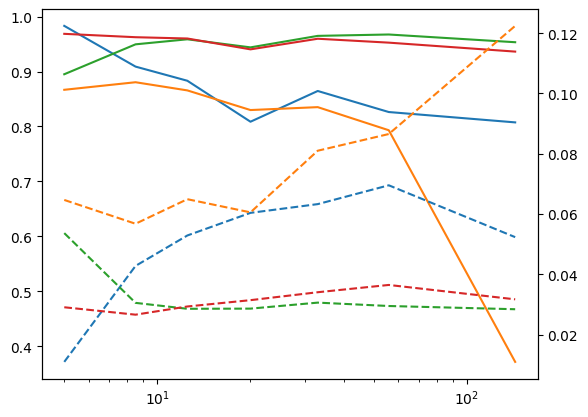

In [422]:
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(tmp['n_nodes_bin'], tmp['r2_min_max'], ls='solid')
ax1.plot(tmp['n_nodes_bin'], tmp['r2_rmin_max'], ls='solid')
ax1.plot(tmp['n_nodes_bin'], tmp['r2_integral'], ls='solid')
ax1.plot(tmp['n_nodes_bin'], tmp['r2_final'], ls='solid')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_min_max'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_rmin_max'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_integral'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_final'], ls='dashed')
plt.xscale('log')

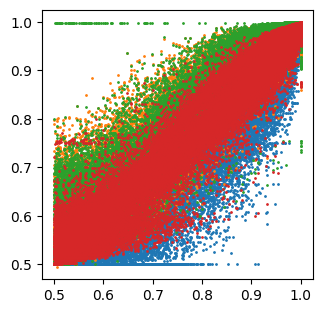

In [423]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(data_eq['auc'], data_eq['auc_min_max_best_nw'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_integral_roc_best'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_integral_joint_best'], s=1)
plt.scatter(data_eq['auc'], data_eq['auc_final_best'], s=1)

In [424]:
(r2_score(data_eq['auc'], data_eq['auc_min_max_best_nw']),
r2_score(data_eq['auc'], data_eq['auc_rmin_max_best_nw']),
r2_score(data_eq['auc'], data_eq['auc_min_maxa_best_nw']),
r2_score(data_eq['auc'], data_eq['auc_rmin_maxa_best_nw']),
r2_score(data_eq['auc'], data_eq['auc_integral_joint_best']),
r2_score(data_eq['auc'], data_eq['auc_integral_roc_best']),
r2_score(data_eq['auc'], data_eq['auc_final_best']))

(0.8504617629108224,
 0.7172120441455948,
 0.6583759699431599,
 0.8810263069652237,
 0.894514433575184,
 0.8827413459484725,
 0.9480175533584715)

In [425]:
tmp = data_eq.groupby(['n_nodes_bin', 'classifier']).apply(lambda pdf: 
        pd.Series({'r2_min_max': calculate_r2(pdf, 'auc_min_max_best_nw'),
                   'r2_rmin_max': calculate_r2(pdf, 'auc_rmin_max_best_nw'),
                   'r2_integral': calculate_r2(pdf, 'auc_integral_joint_best'),
                   'r2_final': calculate_r2(pdf, 'auc_final_best'),
                   'count': len(pdf)})).reset_index(drop=False)

/tmp/ipykernel_1181145/3926694275.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data_eq.groupby(['n_nodes_bin', 'classifier']).apply(lambda pdf:


In [426]:
tmp

,n_nodes_bin,classifier,r2_min_max,r2_rmin_max,r2_integral,r2_final,count
0,5.0,DecisionTreeClassifier,0.028356,0.116507,0.074803,0.042507,8754.0
1,5.0,KNeighborsClassifier,0.048375,0.071101,0.045650,0.029710,3102.0
2,5.0,RandomForestClassifier,0.007564,0.007460,0.016750,0.010666,1285.0
3,5.0,SVC,0.007989,0.008729,0.012347,0.009260,1046.0
4,5.0,XGBClassifier,0.009681,0.008418,0.013568,0.010612,988.0
5,8.5,DecisionTreeClassifier,0.060055,0.128306,0.082412,0.046637,482.0
6,8.5,KNeighborsClassifier,0.080026,0.112198,0.051425,0.041769,2782.0
7,8.5,RandomForestClassifier,0.027964,0.026237,0.027370,0.017591,724.0
8,8.5,SVC,0.025830,0.026325,0.026122,0.019607,907.0
9,8.5,XGBClassifier,0.030050,0.027061,0.026800,0.020880,912.0


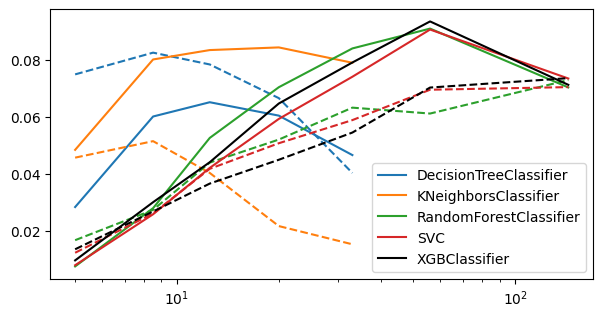

In [427]:
plt.figure(figsize=(7, 3.5))
for idx, classifier in enumerate(tmp['classifier'].drop_duplicates()):
    tmp2 = tmp[tmp['classifier'] == classifier]
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_min_max'], ls='solid', c=colors[idx], label=classifier)
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_integral'], ls='--', c=colors[idx])
    #plt.plot(tmp2['n_nodes_bin'], tmp2['r2_final'], ls=':', c=colors[idx])
plt.xscale('log')
plt.legend()

In [428]:
tmp = data.groupby('n_nodes_bin').apply(lambda pdf: 
        pd.Series({'r2_min_max': r2_score(pdf['auc'], pdf['auc_min_max_best_nw']),
                   'r2_rmin_max': r2_score(pdf['auc'], pdf['auc_rmin_max_best_nw']),
                   'r2_rmin_maxa': r2_score(pdf['auc'], pdf['auc_rmin_maxa_best_nw']),
                   'r2_integral': r2_score(pdf['auc'], pdf['auc_integral_joint_best']),
                   'r2_final': r2_score(pdf['auc'], pdf['auc_final_best']),
                   'mape_min_max': mean_absolute_percentage_error(pdf['auc'], pdf['auc_min_max_best_nw']),
                   'mape_rmin_max': mean_absolute_percentage_error(pdf['auc'], pdf['auc_rmin_max_best_nw']),
                   'mape_rmin_maxa': mean_absolute_percentage_error(pdf['auc'], pdf['auc_rmin_maxa_best_nw']),
                   'mape_integral': mean_absolute_percentage_error(pdf['auc'], pdf['auc_integral_joint_best']),
                   'mape_final': mean_absolute_percentage_error(pdf['auc'], pdf['auc_final_best']),
                   'count': len(pdf)})).reset_index(drop=False)

/tmp/ipykernel_1181145/3403290292.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data.groupby('n_nodes_bin').apply(lambda pdf:


In [429]:
tmp

,n_nodes_bin,r2_min_max,r2_rmin_max,r2_rmin_maxa,r2_integral,r2_final,mape_min_max,mape_rmin_max,mape_rmin_maxa,mape_integral,mape_final,count
0,5.0,0.933705,0.754216,0.920948,0.891109,0.957110,0.028068,0.083525,0.038521,0.055636,0.032827,15175.0
1,8.5,0.827797,0.760817,0.882573,0.902509,0.939244,0.055563,0.076034,0.050635,0.043178,0.032416,5807.0
2,12.5,0.812117,0.743678,0.874762,0.909565,0.939796,0.063685,0.084919,0.056333,0.042406,0.034366,6046.0
3,20.0,0.718360,0.728826,0.817384,0.868794,0.915244,0.068659,0.072903,0.059141,0.044194,0.035604,5307.0
4,33.0,0.771748,0.667991,0.829394,0.879162,0.937257,0.079721,0.110968,0.075495,0.059058,0.042015,5963.0
5,56.0,0.690602,0.535303,0.769241,0.832735,0.921509,0.091584,0.126471,0.084951,0.067378,0.046235,7042.0
6,143.5,0.655305,-0.671998,0.639070,0.681566,0.879894,0.071829,0.197162,0.078926,0.072160,0.044536,3116.0


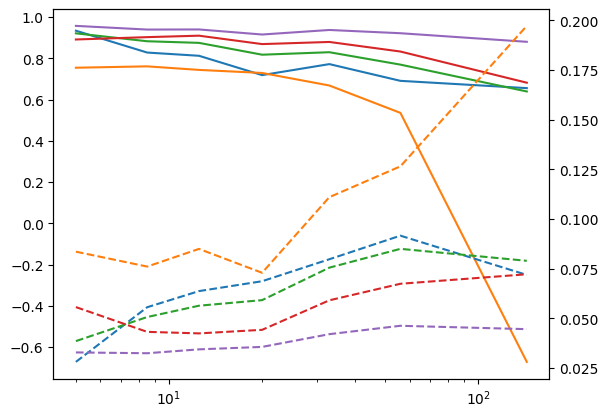

In [430]:
ax1 = plt.subplot()
ax2 = plt.twinx()
ax1.plot(tmp['n_nodes_bin'], tmp['r2_min_max'])
ax1.plot(tmp['n_nodes_bin'], tmp['r2_rmin_max'])
ax1.plot(tmp['n_nodes_bin'], tmp['r2_rmin_maxa'])
ax1.plot(tmp['n_nodes_bin'], tmp['r2_integral'])
ax1.plot(tmp['n_nodes_bin'], tmp['r2_final'])
ax2.plot(tmp['n_nodes_bin'], tmp['mape_min_max'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_rmin_max'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_rmin_maxa'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_integral'], ls='dashed')
ax2.plot(tmp['n_nodes_bin'], tmp['mape_final'], ls='dashed')
plt.xscale('log')

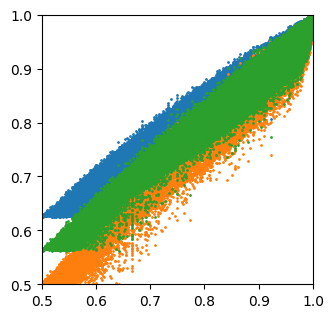

In [431]:
plt.figure(figsize=(3.5, 3.5))
plt.xlim((0.5, 1.0))
plt.ylim((0.5, 1.0))
plt.scatter(data_eq['best_acc'], data_eq['max_acc_min_max'], s=1)
plt.scatter(data_eq['best_acc'], data_eq['max_acc_integral'], s=1)
plt.scatter(data_eq['best_acc'], data_eq['max_acc_final'], s=1)

In [432]:
skew(data_eq['best_acc'] - data_eq['max_acc_final'])

np.float64(0.15719019183066738)

In [433]:
(r2_score(data_eq['best_acc'], data_eq['max_acc_min_max']),
r2_score(data_eq['best_acc'], data_eq['max_acc_integral']),
r2_score(data_eq['best_acc'], data_eq['max_acc_final']))

(0.8706086103529596, 0.9281397161747473, 0.9491926932370038)

In [434]:
tmp = data.groupby('n_nodes_bin').apply(lambda pdf: 
        pd.Series({'r2_min_max': r2_score(pdf['best_acc'], pdf['max_acc_min_max']),
                   'r2_integral': r2_score(pdf['best_acc'], pdf['max_acc_integral']),
                   'r2_final': r2_score(pdf['best_acc'], pdf['max_acc_final'])}))

/tmp/ipykernel_1181145/3505634563.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data.groupby('n_nodes_bin').apply(lambda pdf:


In [435]:
tmp

,r2_min_max,r2_integral,r2_final
n_nodes_bin,,,
5.0,0.878525,0.901044,0.929299
8.5,0.880119,0.910262,0.935010
12.5,0.877440,0.926299,0.947846
20.0,0.888803,0.889917,0.945796
33.0,0.873595,0.929197,0.964856
56.0,0.760082,0.940115,0.957091
143.5,0.230125,0.940436,0.868617
